In [1]:
import numpy as np
import pandas as pd
import gzip
import json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Luxury_Beauty_5.json.gz')

In [2]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN


In [3]:
df['ting'] = 1

In [72]:
df.groupby('reviewerID')['ting'].count().value_counts()

5      1186
6       691
8       585
7       327
9       200
       ... 
46        1
48        1
50        1
52        1
127       1
Name: ting, Length: 62, dtype: int64

In [73]:
sum(df['overall'].isnull())

0

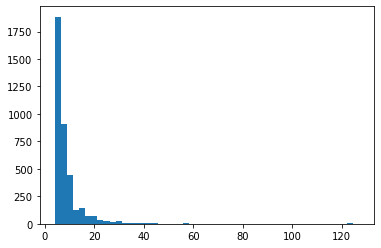

In [74]:
import matplotlib.pyplot as plt
plt.hist(df.groupby('reviewerID')['ting'].count(), bins =50)
plt.show()

In [75]:
df['reviewerID'].unique()

array(['A2HOI48JK8838M', 'A1YIPEY7HX73S7', 'A2QCGHIJ2TCLVP', ...,
       'A2L0GS3N2CXDWC', 'ABBLKU5YUWVXH', 'A36VWPU7SXWOFG'], dtype=object)

In [76]:
df[df['reviewerID'] == 'A2HOI48JK8838M'].index.values

array([    0,    14,  3710,  4542, 14651, 23715, 23905, 25734, 28192])

In [4]:
# make train/test set
train_inds = []
for user in df['reviewerID'].unique():
    inds = df[df['reviewerID'] == user].index.values
    t_inds = inds[np.random.choice(len(inds), size = int(len(inds)*0.8), replace=False)]
    for val in t_inds:
        train_inds.append(val)


In [5]:
test_inds = list(set(df.index.values)-set(train_inds))

In [6]:
assert len(train_inds) == len(set(train_inds)), "Repeat values found in train indices"
assert len(test_inds) == len(list(set(test_inds))), "Repeat values found in test indices"
       

In [7]:
train_df = df.iloc[train_inds]
test_df = df.iloc[test_inds]

train_df.shape

(26087, 13)

In [12]:
train_df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,ting
28192,5.0,True,"03 27, 2016",A2HOI48JK8838M,B00UJTDAJA,NaN,DB,"Fine lines are decreasing, more suppleness. Th...",It's working!!!,1459036800,5,NaN,1
14,3.0,True,"08 14, 2016",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 3.5 oz.'},DB,There is no evidence to me that this product i...,Paying for the name,1471132800,NaN,NaN,1
4542,3.0,True,"08 14, 2016",A2HOI48JK8838M,B000Q39MBY,NaN,DB,I truthfully could not differentiate the resul...,Paying for the name.,1471132800,NaN,NaN,1
23905,3.0,True,"08 14, 2016",A2HOI48JK8838M,B00FRERO7G,"{'Size:': ' 3.45 oz', 'Color:': ' 3.45 oz'}",DB,There is no evidence to me that this product i...,Paying for the name,1471132800,NaN,NaN,1
23715,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00FASVFI8,"{'Size:': ' 0.9 oz', 'Scent:': ' Gardeners'}",DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN,1


In [11]:
train_df['overall'].value_counts(dropna=False)

5.0    15201
4.0     5999
3.0     2946
2.0     1133
1.0      808
Name: overall, dtype: int64

In [13]:
from surprise import Dataset
from surprise import Reader


reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_df[['reviewerID', 'asin', 'overall']], reader)

In [14]:
from surprise import SVD
from surprise.model_selection import cross_validate
svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9488  0.9289  0.9226  0.9334  0.0112  
MAE (testset)     0.7077  0.7031  0.7007  0.7039  0.0029  
Fit time          0.51    0.51    0.53    0.52    0.01    
Test time         0.08    0.11    0.07    0.09    0.02    


{'test_rmse': array([0.94880209, 0.92893513, 0.92259108]),
 'test_mae': array([0.70768755, 0.70312309, 0.70074559]),
 'fit_time': (0.5111408233642578, 0.5123746395111084, 0.5293600559234619),
 'test_time': (0.08136487007141113, 0.11389923095703125, 0.06658387184143066)}

In [22]:
num_right = 0
for i in range(test_df.shape[0]):
    uid = test_df['reviewerID'].iloc[i]
    iid = test_df['asin'].iloc[i]
    prediction = round(svd.predict(uid=uid, iid=iid)[3])
    if prediction == test_df['overall'].iloc[i]:
        num_right+=1
print('Accuracy: {}%'.format(num_right*100/test_df.shape[0]))    

Accuracy: 42.00952264680747%


In [38]:
svd.predict(uid=uid, iid=iid)

Prediction(uid='A1ZNYZ2SM5D3HE', iid='B008H2YNDS', r_ui=None, est=4.476807875451734, details={'was_impossible': False})

In [34]:
train_df.set_index('reviewerID').loc[uid]['asin'].values

array(['B00EVTH9PK', 'B004LCZEJK', 'B000C1VYDY', 'B007340K8S',
       'B00MFTOMLC', 'B00AGR7KHS'], dtype=object)

In [40]:
unique_items = set(train_df['asin'].unique())
user_predictions = {}
for i in range(test_df.shape[0]):
    uid = test_df['reviewerID'].iloc[i]
    train_set_viewed = train_df.set_index('reviewerID').loc[uid]['asin'].values
    items_to_predict = list(unique_items-set(train_set_viewed))
    prediction_rank = {}
    for item in items_to_predict:
        prediction_rank[item] =  svd.predict(uid=uid, iid=item)[3]
    sorted_predictions = {k: v for k, v in sorted(prediction_rank.items(), key=lambda item: item[1], reverse=True)}
    top_predicted_items = list(sorted_predictions.keys())[:10]
    user_predictions[uid] = top_predicted_items
user_predictions

{'AYUF7YETYOLNX': ['B007EZ0CC0',
  'B0015Z532O',
  'B000MIH34Q',
  'B004J0XOTQ',
  'B00837YY18',
  'B00LA5NKTM',
  'B00AAV845M',
  'B001PMIN10',
  'B0001EL9BO',
  'B001GAOUZY'],
 'A3HG0DNFURFXR4': ['B0015Z532O',
  'B00BPJ18DS',
  'B00UKLH4SU',
  'B0001EL9BO',
  'B000PZA2KS',
  'B00110S3GG',
  'B000YBNL2Y',
  'B01C8278QQ',
  'B001GAOUZY',
  'B008MAPGEK'],
 'AWCJ12KBO5VII': ['B0002H842C',
  'B000YBNL2Y',
  'B000ZOFUOC',
  'B00837YY18',
  'B00166M14A',
  'B0013B53DY',
  'B002D48QUC',
  'B00LA5NKTM',
  'B0009OAGVA',
  'B00YHMQDC6'],
 'A1606LA683WZZU': ['B000YBNL2Y',
  'B0015Z532O',
  'B00I5K7XSY',
  'B0009OAGVA',
  'B00110S3GG',
  'B0002H842C',
  'B00B27040G',
  'B016N2SDVG',
  'B000OOSHAM',
  'B0010OKF7S'],
 'A3TCMJ6GKZJFBQ': ['B00LA5NKTM',
  'B004J0XOTQ',
  'B0007M11XQ',
  'B000YBNL2Y',
  'B00AAV845M',
  'B0015Z532O',
  'B0013U0EYI',
  'B00B27040G',
  'B00170BJD4',
  'B00T07GQ3E'],
 'A1QO88MU0PYJON': ['B000YBNL2Y',
  'B005CBWYME',
  'B003OGV7UO',
  'B00172O9NO',
  'B000NG80GM',
  'B00CNE

In [41]:
df=pd.DataFrame.from_dict(user_predictions,orient='columns')
df

,AYUF7YETYOLNX,A3HG0DNFURFXR4,AWCJ12KBO5VII,A1606LA683WZZU,A3TCMJ6GKZJFBQ,A1QO88MU0PYJON,A2FN8FBQAKOZ3B,A1Y39RECFXEGNL,A141R97FHSSUQ0,AWVF9EWW3BXYV,...,A1EYDV7OQE5BLC,ASGIVOW34XNQS,A3HDIZAWPFGVWG,A1QPLOGZM1F7E8,AE0337VVP8MRM,A13JH2NRRR2NF6,A2CWIYIETNBAK3,A181TIQPGSTYH6,A36VWPU7SXWOFG,A3QS776PDEZ773
0,B007EZ0CC0,B0015Z532O,B0002H842C,B000YBNL2Y,B00LA5NKTM,B000YBNL2Y,B000YBNL2Y,B000YBNL2Y,B000WMWR1G,B000YBNL2Y,...,B000YBNL2Y,B0009OAGVA,B000ZOFUOC,B00LA5NKTM,B000YBNL2Y,B000YBNL2Y,B004J0XOTQ,B000YBNL2Y,B011JFR26Y,B005CBWYME
1,B0015Z532O,B00BPJ18DS,B000YBNL2Y,B0015Z532O,B004J0XOTQ,B005CBWYME,B00110S3GG,B0015Z532O,B000YBNL2Y,B00IZO0LLG,...,B00175YVNO,B000ZOFUOC,B003OGV7UO,B001PMIN10,B0009OAGVA,B004N2S2JM,B0009OAGVA,B00LA5NKTM,B000MIH34Q,B004J0XOTQ
2,B000MIH34Q,B00UKLH4SU,B000ZOFUOC,B00I5K7XSY,B0007M11XQ,B003OGV7UO,B00R69ZDW8,B0009OAGVA,B0015ZAOLY,B00SXM70UA,...,B0015Z532O,B000YBNL2Y,B008MAPGEK,B0002H842C,B003OGV7UO,B000P6W6XI,B000YBNL2Y,B000142FVW,B000YBNL2Y,B000YBNL2Y
3,B004J0XOTQ,B0001EL9BO,B00837YY18,B0009OAGVA,B000YBNL2Y,B00172O9NO,B001QRG190,B004J0XOTQ,B000NG80GM,B00110U75Q,...,B000PZA2KS,B001GAOUZY,B001AO0WCG,B000YBNL2Y,B00175YVNO,B0015VN6V8,B000VN8K2G,B0009OAGVA,B0010OKF7S,B000WMWR1G
4,B00837YY18,B000PZA2KS,B00166M14A,B00110S3GG,B00AAV845M,B000NG80GM,B00110S21M,B001GAOUZY,B0002H842C,B001GAOUZY,...,B0015VN6V8,B004J0XOTQ,B001GAOUZY,B0009OAGVA,B0013U0EYI,B00837YY18,B0002OZ018,B0015VN6V8,B0009OAGVA,B0009OAGVA
5,B00LA5NKTM,B00110S3GG,B0013B53DY,B0002H842C,B0015Z532O,B00CNE2GOO,B0015VN6V8,B00LA5NKTM,B004KIB688,B0015Z532O,...,B01DQG37VS,B00R69ZDW8,B0002H842C,B008MAPGEK,B00837YY18,B007EZ0CC0,B01ELU4DSE,B0018APVTG,B0002H842C,B01C8278QQ
6,B00AAV845M,B000YBNL2Y,B002D48QUC,B00B27040G,B0013U0EYI,B0045WAXTC,B001GAOUZY,B00110S3GG,B004BWBFSY,B0013B53DY,...,B000XYPNMS,B000MIH34Q,B000MIH34Q,B0015Z532O,B00175YVOS,B000PZA2KS,B000WN5EGA,B000UV7FXE,B0006O4M8Q,B000NG80GM
7,B001PMIN10,B01C8278QQ,B00LA5NKTM,B016N2SDVG,B00B27040G,B00166M14A,B00ZY65RUI,B0015VN6V8,B011JFR26Y,B004N2SQUC,...,B0009OAGVA,B0015Z532O,B00U1E54CE,B00BD3R1PU,B00176B8BG,B00110S21M,B0013U0EYI,B0002H842C,B00837YY18,B0015Z532O
8,B0001EL9BO,B001GAOUZY,B0009OAGVA,B000OOSHAM,B00170BJD4,B002D48QUC,B00I5K7XSY,B000PZA2KS,B00172PC3A,B00846H9WY,...,B00AAV845M,B00LA5NHXQ,B0001EL5R2,B000WN5EGA,B001GAOUZY,B00LA5NKTM,B000ULD9XE,B00CNE2GOO,B000WMWR1G,B0002OZ018
9,B001GAOUZY,B008MAPGEK,B00YHMQDC6,B0010OKF7S,B00T07GQ3E,B011JFR26Y,B0009OAGVA,B007EZ0CC0,B00LA5NKTM,B00837YY18,...,B00LA5NKTM,B00175YVNO,B00AAV845M,B002D48QRK,B001543FF2,B000IOBEG2,B000ZOFUOC,B004J0XOTQ,B00ZY65RUI,B00080DK86


In [42]:
df.to_csv('user_predictions.csv')